In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from scipy import linalg

In [2]:
from filters import imm, kalman
from models import const_acc, const_vel, noise
from plots import plot_adaptive, plot_common, plot_kf
from simulators import maneuver

## Adaptive Filters


[Text(0.5, 1.0, 'Track vs Measurements'), Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

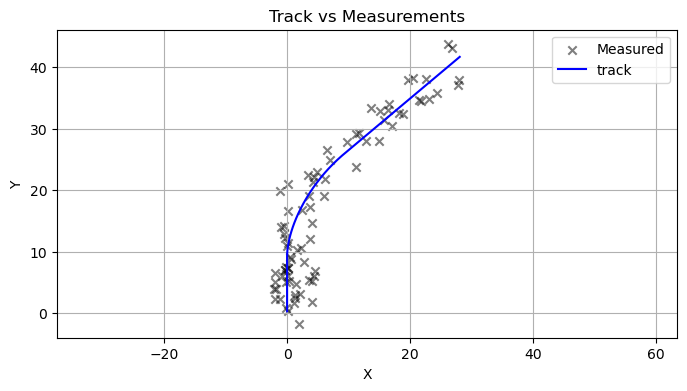

In [3]:
sensor_std = 2.0
track, zs = maneuver.simulate_maneuver(50, sensor_std)

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, *zip(*zs), alpha=0.5)
ax.plot(*zip(*track), color="b", label="track")
ax.axis("equal")
ax.legend()
ax.set(title="Track vs Measurements", xlabel="X", ylabel="Y")

### Kalman CV


In [4]:
def init_filter(kf, std_R=None):
    kf.x.fill(0.0)
    kf.P = np.eye(kf.dim_x) * 0.1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

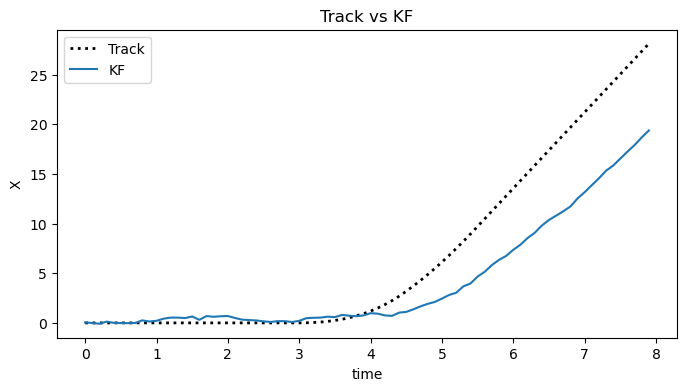

In [5]:
sensor_std = 2.0
dt = 0.1
kf_cv = const_vel.KFCV2d(P=3, R=sensor_std, Q=0.02, dt=dt)
init_filter(kf_cv)
track, zs = maneuver.simulate_maneuver(50, sensor_std)
# run it
z_xs = zs[:, 0]
kxs, _, _, _ = kf_cv.batch_filter(z_xs)

# plot results
_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_track(ax, track[:, 0], dt=dt)
plot_kf.plot_kf(ax, kxs[:, 0], dt=dt, label="KF")
ax.set(title="Track vs KF", xlabel="time", ylabel="X")
ax.legend()

# plt.savefig("../images/adaptive-kf-cv.png")

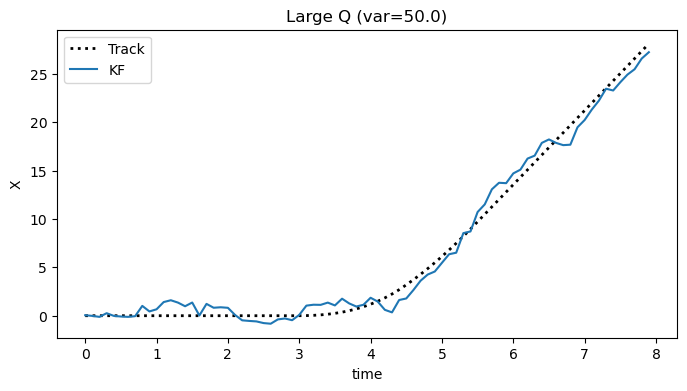

In [6]:
dt = 0.1
init_filter(kf_cv)
kf_cv.Q = noise.white_noise_discrete(dim=2, dt=dt, var=50.0)

track2, zs2 = maneuver.simulate_maneuver(50, sensor_std)
# recompute track
xs2 = track2[:, 0]
z_xs2 = zs2[:, 0]
kxs2, _, _, _ = kf_cv.batch_filter(z_xs2)

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_track(ax, xs2, dt=dt)
plot_kf.plot_kf(ax, kxs2[:, 0], dt=dt, label="KF")
ax.set(title="Large Q (var=50.0)", xlabel="time", ylabel="X")
ax.legend()

# plt.savefig("../images/adaptive-kf-cv-q.png")

### Kalman CA


In [7]:
def init_const_accel(f):
    f.x = np.array([0.0, 0.0, 0.0])
    f.P = np.eye(3) * 3

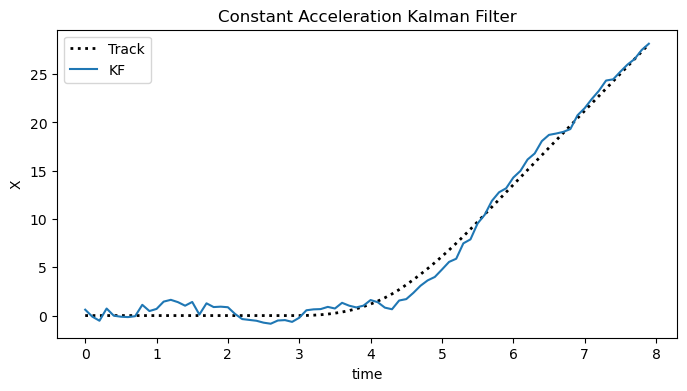

In [8]:
dt = 0.1
kf_ca = const_acc.KFCA3d(P=3, R=2, Q=0.02, dt=dt)
init_const_accel(kf_ca)
kxs2, _, _, _ = kf_ca.batch_filter(z_xs2)

_, ax = plt.subplots(figsize=(8, 4))
plot_common.plot_track(ax, xs2, dt=dt)
plot_kf.plot_kf(ax, kxs2[:, 0], dt=dt, label="KF")
ax.set(title="Constant Acceleration Kalman Filter", xlabel="time", ylabel="X")
ax.legend()

# plt.savefig("../images/adaptive-kf-ca.png")

## Detecting Manoeuvring


### Residual


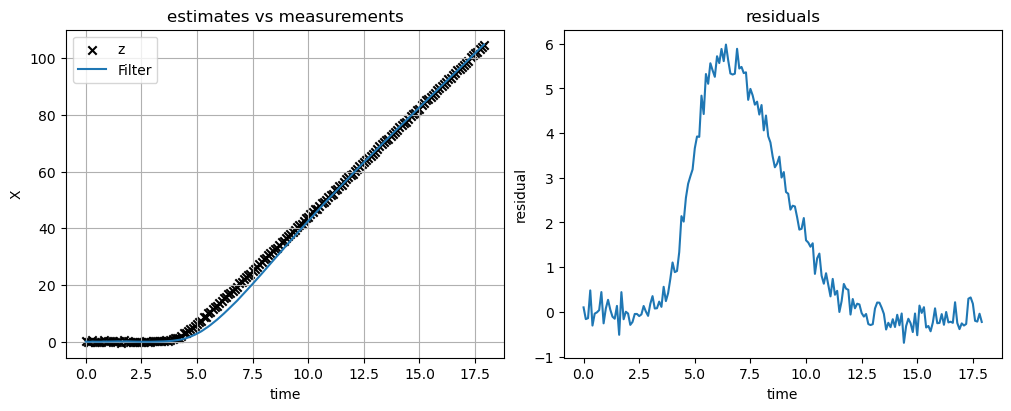

In [9]:
dt = 0.1
sensor_std = 0.2
# initialize filter
kf_cv = const_vel.KFCV2d(P=3, R=sensor_std, Q=0.02, dt=dt)
init_filter(kf_cv)
pos2, zs2 = maneuver.simulate_maneuver(150, sensor_std)
xs2, z_xs2 = pos2[:, 0], zs2[:, 0]
kf_cv.Q = noise.white_noise_discrete(dim=2, dt=dt, var=0.02)

xs, res = [], []
for z in z_xs2:
    kf_cv.predict()
    kf_cv.update([z])
    xs.append(kf_cv.x[0])
    res.append(kf_cv.y[0])
xs = np.asarray(xs)

_, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)


plot_kf.plot_kf_with_resids(axes, dt, xs, z_xs2, res)

# plt.savefig("../images/adaptive-residual.png")

### Process Noise


[Text(0.5, 1.0, 'residual vs time'), Text(0.5, 0, 'time'), Text(0, 0.5, 'ϵ')]

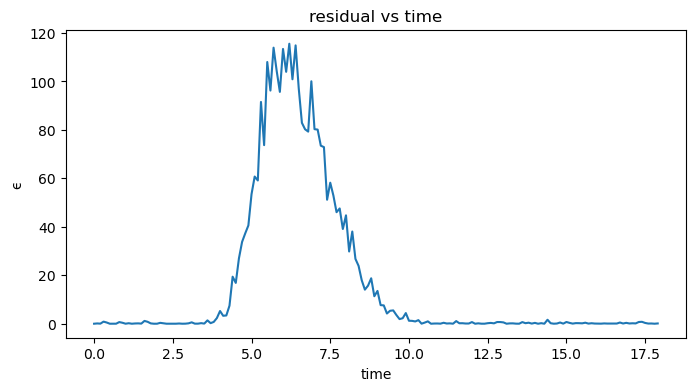

In [10]:
dt = 0.1
sensor_std = 0.2
kf_cv = const_vel.KFCV2d(P=3, R=sensor_std, Q=sensor_std**2, dt=dt)
_, zs2 = maneuver.simulate_maneuver(150, sensor_std)

epss = []
for z in zs2[:, 0]:
    kf_cv.predict()
    kf_cv.update([z])
    y, S = kf_cv.y, kf_cv.S
    eps = np.dot(y.T, linalg.inv(S)).dot(y).flatten()
    epss.append(eps)

_, ax = plt.subplots(figsize=(8, 4))

t = np.arange(0, len(epss) * dt, dt)
ax.plot(t, epss)
ax.set(title="residual vs time", xlabel="time", ylabel="ϵ")

# plt.savefig("../images/adaptive-kf-residual.png")

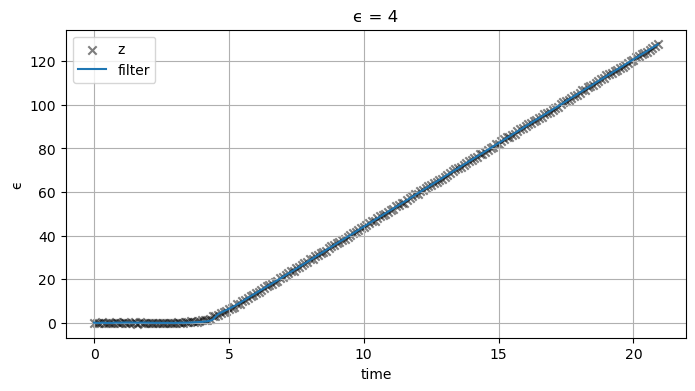

In [11]:
dt = 0.1
sensor_std = 0.2
kf_cv = const_vel.KFCV2d(P=3, R=sensor_std, Q=sensor_std**2, dt=dt)
_, zs2 = maneuver.simulate_maneuver(180, sensor_std)
Q_scale_factor = 1000.0
eps_max = 4.0
xs, epss = [], []
count = 0

for z in zs2[:, 0]:
    kf_cv.predict()
    kf_cv.update([z])
    y, S = kf_cv.y, kf_cv.S
    eps = np.dot(y.T, linalg.inv(S)).dot(y)
    epss.append(eps)
    xs.append(kf_cv.x[0])
    if eps > eps_max:
        kf_cv.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        kf_cv.Q /= Q_scale_factor
        count -= 1

_, ax = plt.subplots(figsize=(8, 4))

t = np.arange(0, len(epss) * dt, dt)
plot_common.plot_zs(ax, zs2[:, 0], dt=dt, label="z", alpha=0.5)
plot_kf.plot_kf(ax, t, xs, dt=dt, label="filter")
ax.set(title="ϵ = 4", xlabel="time", ylabel="ϵ")
ax.legend()

# plt.savefig("../images/adaptive-kf-e.png")

### Zarchan Method


In [12]:
def adkf_zarchan(Q_scale_factor, std_scale, dt=0.1):
    kf_cv = const_vel.KFCV2d(P=3, R=0.2, Q=sensor_std**2, dt=dt)
    pos2, zs2 = maneuver.simulate_maneuver(180 - 30, std=0.2)
    _, z_xs2 = pos2[:, 0], zs2[:, 0]

    init_filter(kf_cv)
    kf_cv.R = np.eye(1) * 0.2
    phi = 0.02
    kf_cv.Q = noise.white_noise_discrete(dim=2, dt=dt, var=phi)

    xs, ys = [], []
    count = 0

    for z in z_xs2:
        kf_cv.predict()
        kf_cv.update([z])
        y = kf_cv.y
        S = kf_cv.S
        std = np.sqrt(S)
        xs.append(kf_cv.x)
        ys.append(y)

        if abs(y[0]) > std_scale * std:
            phi += Q_scale_factor
            count += 1
        elif count > 0:
            phi -= Q_scale_factor
            count -= 1
        kf_cv.Q = noise.white_noise_discrete(2, dt, phi)

    return np.asarray(xs), z_xs2

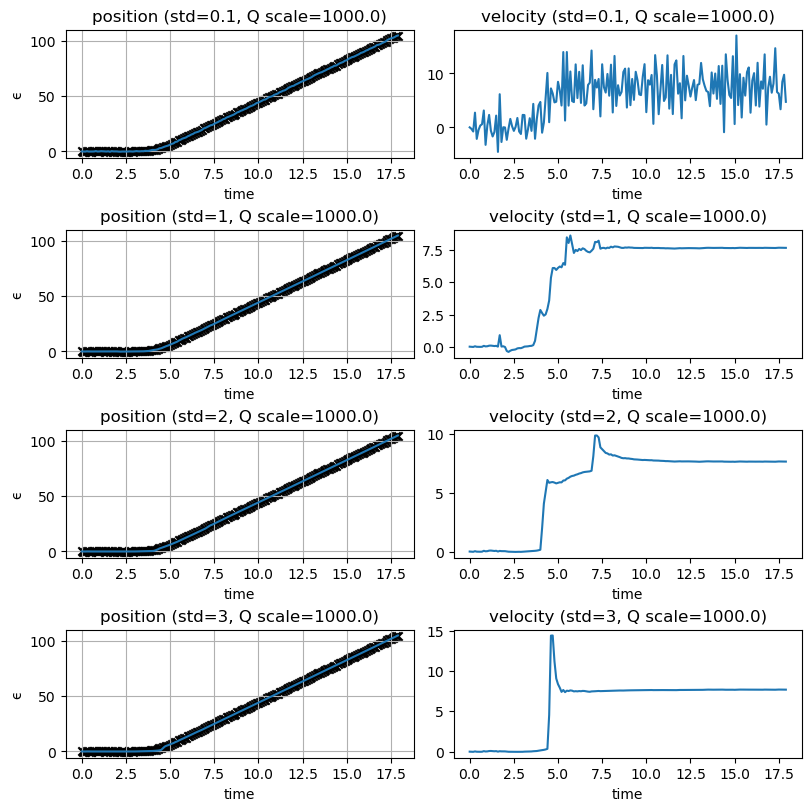

In [13]:
std_scales = [0.1, 1, 2, 3]
dt = 0.1

_, axes = plt.subplots(len(std_scales), 2, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

for ind, std_scale in enumerate(std_scales):
    xs, z_xs2 = adkf_zarchan(1000, std_scale)
    plot_adaptive.plot_adkf_2d(
        axes[ind * 2 : ind * 2 + 2],
        xs,
        z_xs2,
        dt=dt,
        Q_scale_factor=Q_scale_factor,
        std_scale=std_scale,
        std_title=True,
    )

# plt.savefig("../images/adkf-zarchan-std.png")

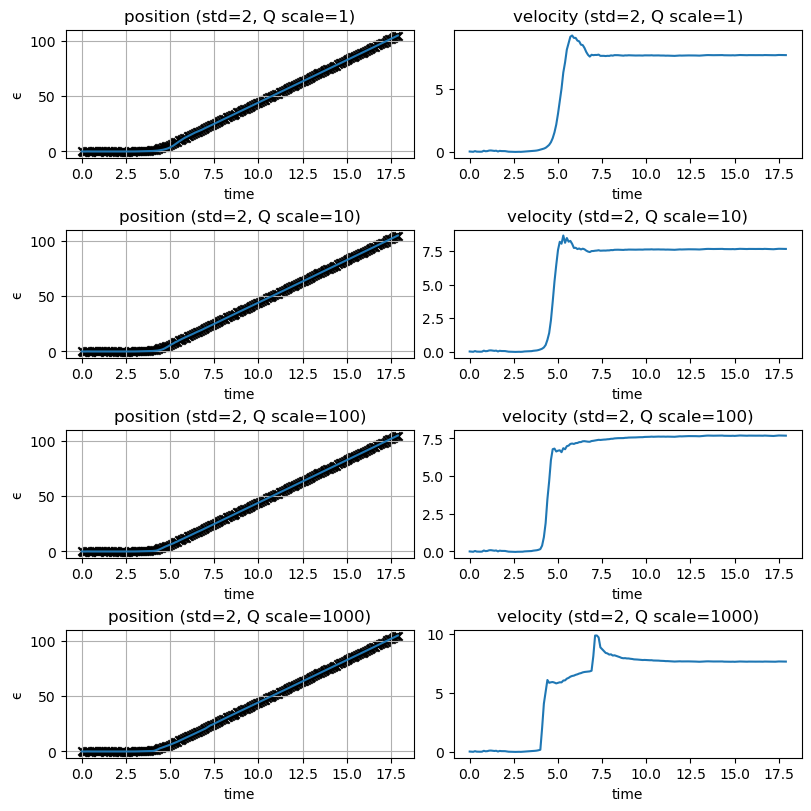

In [14]:
Q_scale_factors = [1, 10, 100, 1000]
std_scale = 2
dt = 0.1

_, axes = plt.subplots(len(Q_scale_factors), 2, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

for ind, Q_scale_factor in enumerate(Q_scale_factors):
    xs, z_xs2 = adkf_zarchan(Q_scale_factor, std_scale)
    plot_adaptive.plot_adkf_2d(
        axes[ind * 2 : ind * 2 + 2],
        xs,
        z_xs2,
        dt=dt,
        Q_scale_factor=Q_scale_factor,
        std_scale=std_scale,
        Q_title=True,
    )

# plt.savefig("../images/adkf-zarchan-q.png")

## Multiple Model


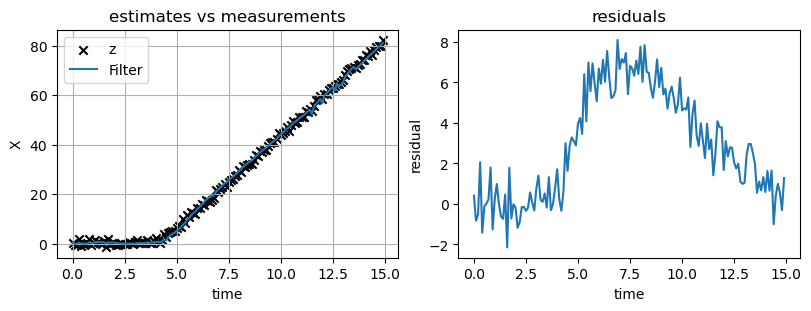

In [15]:
def run_filter_bank(axes, threshold, show_zs=True):
    dt = 0.1
    kf_cv = const_vel.KFCV2d(P=3, R=0.8, Q=0.02, dt=dt)
    kf_ca = const_acc.KFCA3d(P=3, R=0.8, Q=0.02, dt=dt)
    pos, zs = maneuver.simulate_maneuver(120, std=0.8)
    z_xs = zs[:, 0]
    xs, res = [], []
    for z in z_xs:
        kf_cv.predict()
        kf_ca.predict()
        kf_cv.update([z])
        kf_ca.update([z])
        std = np.sqrt(kf_cv.R[0, 0])
        if abs(kf_cv.y[0]) < 2 * std:
            xs.append(kf_cv.x[0])
        else:
            xs.append(kf_ca.x[0])
        res.append(kf_cv.y[0])

    xs = np.asarray(xs)

    if show_zs:
        plot_kf.plot_kf_with_resids(axes, dt, xs, z_xs, res)
    else:
        plot_kf.plot_kf_with_resids(axes, dt, xs, None, res)


_, axes = plt.subplots(
    1,
    2,
    figsize=(8, 3),
    constrained_layout=True,
)

run_filter_bank(axes, threshold=1.4)

# plt.savefig("../images/adkf-mm.png")

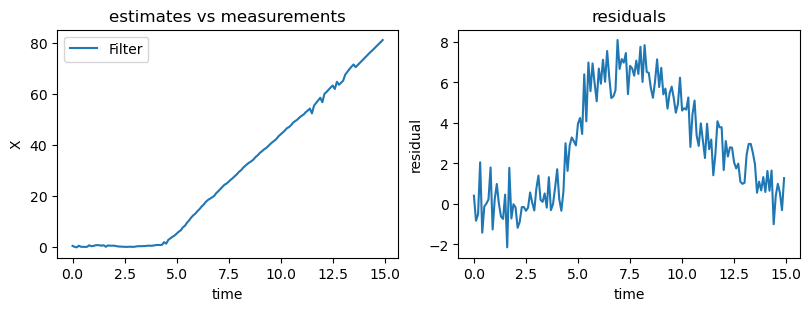

In [16]:
_, axes = plt.subplots(
    1,
    2,
    figsize=(8, 3),
    constrained_layout=True,
)

run_filter_bank(axes, threshold=1.4, show_zs=False)

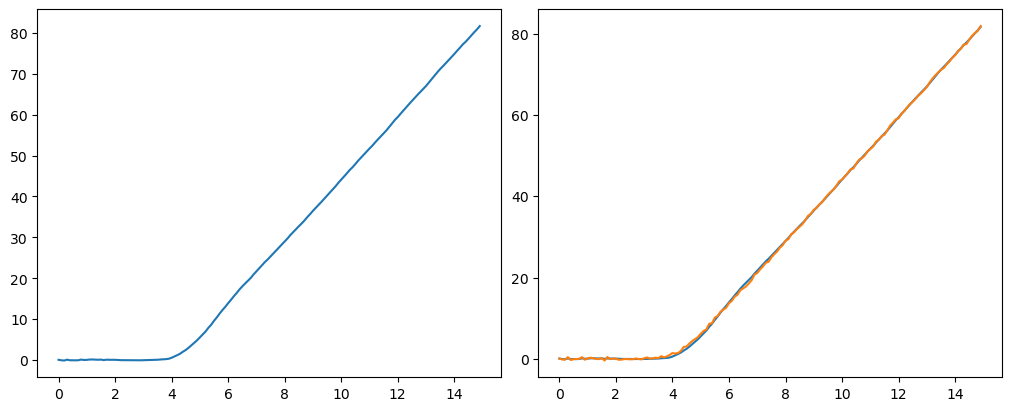

In [17]:
def run_filter_bank(axes):
    dt = 0.1
    kf_cv = const_vel.KFCV2d(P=3, R=0.2, Q=0.02, dt=dt)
    kf_ca = const_acc.KFCA3d(P=3, R=0.2, Q=0.02, dt=dt)

    _, zs = maneuver.simulate_maneuver(120, std=0.2)
    z_xs = zs[:, 0]
    xs, probs = [], []
    pv, pa = 0.8, 0.2

    for z in z_xs:
        kf_cv.predict()
        kf_ca.predict()
        kf_cv.update([z])
        kf_ca.update([z])
        cv_likelihood = kf_cv.likelihood * pv
        ca_likelihood = kf_ca.likelihood * pa
        pv = (cv_likelihood) / (cv_likelihood + ca_likelihood)
        pa = (ca_likelihood) / (cv_likelihood + ca_likelihood)
        x = (pv * kf_cv.x[0]) + (pa * kf_ca.x[0])
        xs.append(x)
        probs.append(pv / pa)

    xs = np.asarray(xs)
    t = np.arange(0, len(xs) * dt, dt)

    axes[0].plot(t, xs)
    axes[1].plot(t, xs)
    axes[1].plot(t, z_xs)
    return xs, probs


_, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    constrained_layout=True,
)

xs, probs = run_filter_bank(axes)

[Text(0.5, 1.0, 'probability ratio p(cv)/p(ca)'), None]

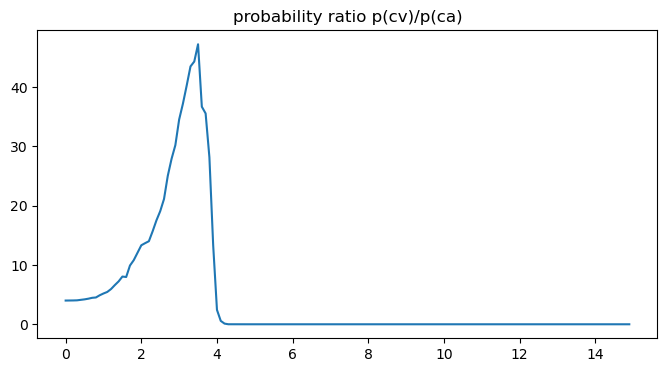

In [18]:
_, ax = plt.subplots(figsize=(8, 4))

dt = 0.1
t = np.arange(0, len(xs) * dt, dt)

ax.plot(t[: len(probs)], probs)
ax.set(title="probability ratio p(cv)/p(ca)", label="time")

### IMM


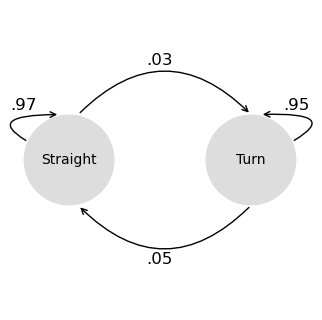

In [19]:
plot_adaptive.show_markov_chain(figsize=(3, 3))

# plt.savefig("../images/adaptive-mc.png")

[(-1.5, 1.5), Text(0.5, 1.0, 'probability ratio p(cv)/p(ca)')]

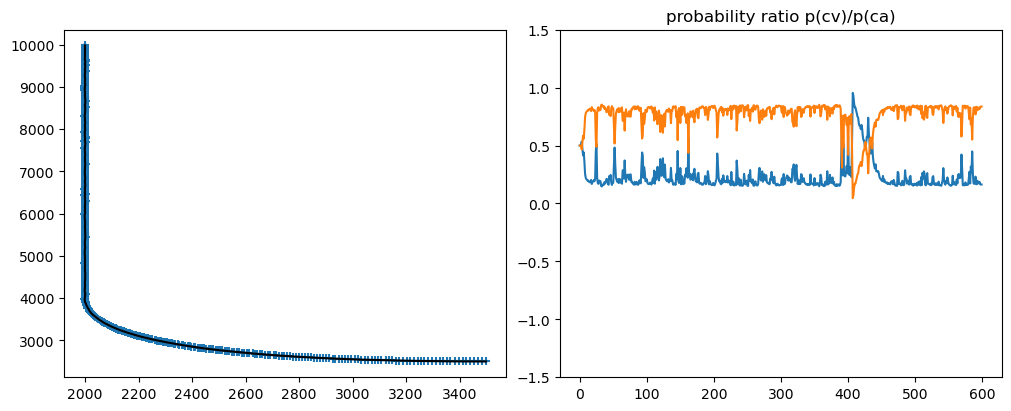

In [20]:
N = 600
dt = 1.0
imm_track = maneuver.simulate_turning(N).reshape(N, 4)

# create noisy measurements
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = imm_track[i, 0] + random.randn() * r
    zs[i, 1] = imm_track[i, 2] + random.randn() * r

kf_ca = kalman.KalmanFilter(6, 2)
F = const_acc.FCA(3, dt)

kf_ca.F = linalg.block_diag(F, F)
kf_ca.x = np.array([[2000.0, 0, 0, 10000, -15, 0]]).T
kf_ca.P *= 1.0e-12
kf_ca.R *= r**2
q = (
    np.array(
        [[0.05, 0.125, 1 / 6], [0.125, 1 / 3, 0.5], [1 / 6, 0.5, 1]],
    )
    * 1.0e-3
)
kf_ca.Q = linalg.block_diag(q, q)
kf_ca.H = np.array([[1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]])

# create identical filter, but with no process error
kf_cano = deepcopy(kf_ca)
kf_cano.Q *= 0

filters = [kf_ca, kf_cano]
M = np.array([[0.97, 0.03], [0.03, 0.97]])
mu = np.array([0.5, 0.5])
bank = imm.IMMEstimator(filters, mu, M)
xs, probs = [], []

for z in zs:
    z = np.array([z]).T
    bank.predict()
    bank.update(z)
    xs.append(bank.x.copy())
    probs.append(bank.mu.copy())

xs = np.array(xs)
probs = np.array(probs)

_, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    constrained_layout=True,
)

axes[0].plot(xs[:, 0], xs[:, 3], "k")
axes[0].scatter(zs[:, 0], zs[:, 1], marker="+")
axes[1].plot(probs[:, 0])
axes[1].plot(probs[:, 1])
axes[1].set(ylim=(-1.5, 1.5), title="probability ratio p(cv)/p(ca)")

## Fading Memory Filter


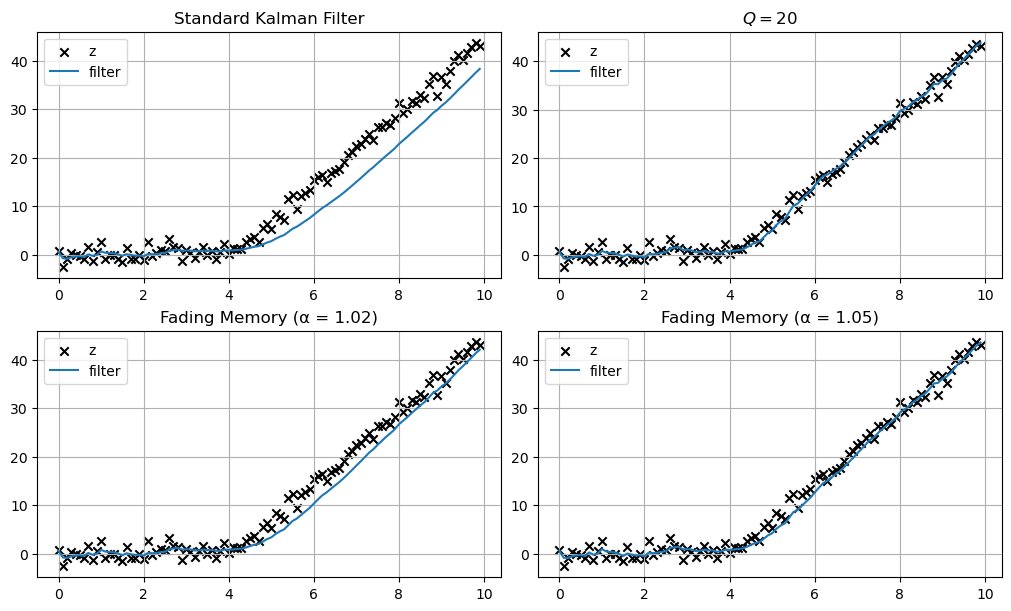

In [21]:
def run_kalman_filter(ax, alpha, sensor_std, var, dt, title):
    kf_cv = const_vel.KFCV2d(P=3, R=sensor_std, Q=var, dt=dt)
    kf_cv.x.fill(0.0)
    kf_cv.Q = noise.white_noise_discrete(dim=2, dt=dt, var=var)
    kf_cv.alpha = alpha

    xs, res = [], []
    for z in z_xs2:
        kf_cv.predict()
        kf_cv.update([z])
        xs.append(kf_cv.x[0])
        res.append(kf_cv.y[0])

    xs = np.asarray(xs)
    plot_common.plot_zs(ax, z_xs2, dt=dt, label="z")
    ax.plot(t[:100], xs, label="filter")
    ax.legend()
    ax.set(title=title)


pos2, zs2 = maneuver.simulate_maneuver(70, std=1.2)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]

# Case 1
_, axes = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)

vars_ = [0.02, 20.0, 0.02, 0.02]
alphas = [1.00, 1.00, 1.02, 1.05]
titles = [
    "Standard Kalman Filter",
    "$Q = 20$",
    "Fading Memory (α = 1.02)",
    "Fading Memory (α = 1.05)",
]
dt = 0.1
sensor_std = 1.2

for ax, var, alpha, title in zip(axes.flatten(), vars_, alphas, titles):
    run_kalman_filter(ax, alpha, sensor_std, var, dt, title)

# plt.savefig("../images/adkf-alpha.png")